In [2]:
# Reload all modules (except those excluded)
%load_ext autoreload
%autoreload 2 

import numpy as np
import matplotlib.pyplot as plt

import stim
print(stim.__version__)
import pymatching
print(pymatching.__version__)

from circDist3RepetitionCode import generate_stim_circuit
from Util_Stim import count_logical_errors

1.16.dev0
2.3.1


In [3]:
import sinter
from typing import List
print(sinter.__version__)
import multiprocessing
import time
print(f"Detected CPU cores: {multiprocessing.cpu_count()}")

1.15.0
Detected CPU cores: 6


Q:Is it possible to tell sinter.collect() to disregard shots for which syndrome has odd parity?
AI A: you can get around this issue by telling Sinter (or your decoder) to skip invalid shots whose syndrome parity is incompatible with the matching algorithm.
    How to filter out invalid shots in Sinter
sinter.collect() itself does not have a direct option like "ignore odd parity shots".

But Sinter does allow custom decoders, and if a decoder returns None for a shot, that shot will be ignored in the final statistics.

So you can wrap your Pymatching decoder with a parity check:

In [5]:
import sinter
import pymatching
import stim

GRAPH_JSON_PATH = "graph.json"  # Pre-exported from your Stim circuit

def make_safe_decoder():
    # This function will be run inside *each* worker, avoiding pickling issues
    import json
    import numpy as np
    with open(GRAPH_JSON_PATH) as f:
        graph_data = json.load(f)
    matcher = pymatching.Matching.from_detector_error_model(graph_data)

    def decode(dets: np.ndarray):
        try:
            return matcher.decode_batch(dets)
        except ValueError:
            return None
    return decode

codeName=    "color_code:memory_xyz"
codeName= "repetition_code:memory"

tasks = [
        sinter.Task(
        circuit=stim.Circuit.generated(
            codeName,
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3,  9]
    for noise in [   0.05, 0.1, 0.2 ]
]

stats = sinter.collect(
    num_workers=6,
    tasks=tasks,
    decoders=[make_safe_decoder],  # Pass function, not object
    max_shots=5000_000,
    max_errors=500,
)

ValueError: Worker failed: traceback=Traceback (most recent call last):
  File "/opt/venv/lib/python3.12/site-packages/sinter/_collection/_collection_worker_state.py", line 243, in run_message_loop
    num_messages_processed = self.process_messages()
                             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/venv/lib/python3.12/site-packages/sinter/_collection/_collection_worker_state.py", line 160, in process_messages
    message = self.inp.get_nowait()
              ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 135, in get_nowait
    return self.get(False)
           ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'make_safe_decoder' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


In [7]:
tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            codeName,
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [  0.01, 0.02, 0.05, 0.1, 0.2 ,0.5]
]

start = time.time()
collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=6,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=5000_000,
    max_errors=500,
)
elapsed = time.time() - start
print(f"Elapsed time: {elapsed:.1f} seconds for {len(collected_stats)} tasks")
print(f"Executed {len(collected_stats)} tasks total.")

RuntimeError: Worker failed: traceback=Traceback (most recent call last):
  File "/opt/venv/lib/python3.12/site-packages/sinter/_collection/_collection_worker_state.py", line 246, in run_message_loop
    did_some_work = self.do_some_work()
                    ^^^^^^^^^^^^^^^^^^^
  File "/opt/venv/lib/python3.12/site-packages/sinter/_collection/_collection_worker_state.py", line 217, in do_some_work
    some_work_done = self.compiled_sampler.sample(self.current_task_shots_left)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/venv/lib/python3.12/site-packages/sinter/_collection/_sampler_ramp_throttled.py", line 51, in sample
    result = self.sub_sampler.sample(actual_shots)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/venv/lib/python3.12/site-packages/sinter/_decoding/_stim_then_decode_sampler.py", line 193, in sample
    predictions = self.compiled_decoder.decode_shots_bit_packed(bit_packed_detection_event_data=dets)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/venv/lib/python3.12/site-packages/sinter/_decoding/_decoding_pymatching.py", line 13, in decode_shots_bit_packed
    return self.matcher.decode_batch(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/venv/lib/python3.12/site-packages/pymatching/matching.py", line 451, in decode_batch
    predictions, weights = self._matching_graph.decode_batch(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: No perfect matching could be found. This likely means that the syndrome has odd parity in the support of a connected component without a boundary.


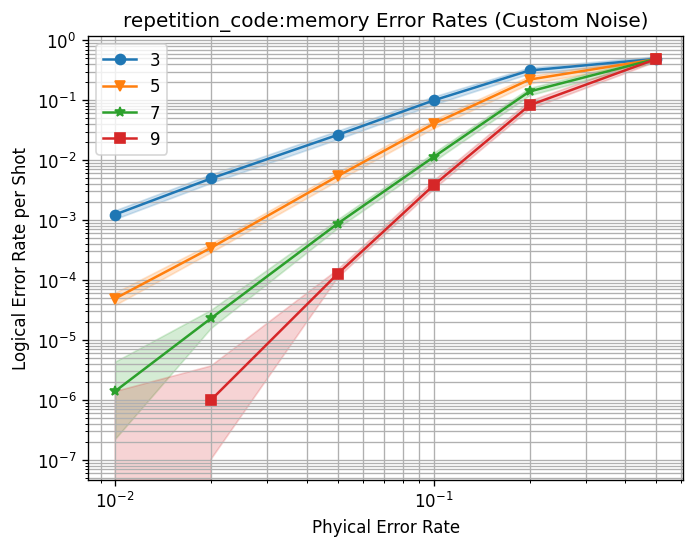

In [6]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title(codeName+" Error Rates (Custom Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger